In [1]:
import numpy as np
import healpy as hp
from astropy.coordinates import cartesian_to_spherical
from src.Calculators.casters import THE_TRIPLE_CASTER
from src.Calculators.legion_of_casters import THROUPLE_S_CASTERS
import matplotlib.pyplot as plt

In [2]:
m = 6
fix = 881
G = 6.6743e-11 # SI
NSIDE = 4
Msol = 1.98847e30 # kg
Rsol = 6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G )) # Follows from G = 1
c = 3e8 * t/Rsol # simulator units. Need these for the PW potential
c_cgs = 3e10 # [cm/s]
Msol_to_g = 1.989e33 # [g]
Rsol_to_cm = 6.957e10 # [cm]
den_converter = Msol_to_g / Rsol_to_cm**3

fix = str(fix)
Mbh = 10**m 
Rt =  Mbh**(1/3) # Msol = 1, Rsol = 1

In [3]:
thetas = np.zeros(192)
phis = np.zeros(192)
observers = []
for i in range(0,192):
    thetas[i], phis[i] = hp.pix2ang(NSIDE, i)
    thetas[i] -= np.pi/2
    phis[i] -= np.pi
    observers.append( (thetas[i], phis[i]) )


In [4]:
radius = np.linspace(0.2*Rt, 10_000, 750)

In [5]:
# for moll we want: theta in [-pi/2, pi/2], phi in [-pi,pi]
print('phi min:', np.min(phis))
print('phi max:', np.max(phis))
print('theta min:', np.min(thetas))
print('theta max:', np.max(thetas))

phi min: -3.141592653589793
phi max: 2.94524311274043
theta min: -1.3663161278263616
theta max: 1.3663161278263618


In [6]:
# phi_grid, theta_grid = np.meshgrid(phis,thetas)
# radius = 3 * phi_grid/phi_grid
# print(radius)
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1, projection='3d')
# plot = ax.plot_surface(phi_grid, theta_grid, radius, cmap ='cet_fire')
# plt.show()

In [7]:
# Import
X = np.load( str(m) + '/'  + fix + '/CMx_' + fix + '.npy')
Y = np.load( str(m) + '/'  + fix + '/CMy_' + fix + '.npy')
Z = np.load( str(m) + '/'  + fix + '/CMz_' + fix + '.npy')
Mass = np.load( str(m) + '/'  + fix + '/Mass_' + fix + '.npy')
T = np.load( str(m) + '/'  + fix + '/T_' + fix + '.npy')
Den = np.load( str(m) + '/'  + fix + '/Den_' + fix + '.npy')
Rad = np.load( str(m) + '/'  +fix + '/Rad_' + fix + '.npy')

In [8]:
Den *= den_converter 
R, THETA, PHI = cartesian_to_spherical(X,Y,Z)
R = R.value 
THETA = THETA.value #from -pi/2 to pi/2
PHI = PHI.value
PHI -= np.pi #from -pi to pi

In [9]:
# have to be in the same range of phis and thetas
print('phi min simul:', np.min(PHI))
print('phi max simul:', np.max(PHI))
print('theta min simul:', np.min(THETA))
print('theta max simul:', np.max(THETA))

phi min simul: -3.141592343305648
phi max simul: 3.141588635023931
theta min simul: -1.56902225202048
theta max simul: 1.5681879547097137


In [10]:
T_casted, _, _ = THROUPLE_S_CASTERS(radius, R, observers, THETA, PHI, T, Den, Rad, weights = Mass, avg = False)

/Users/paolamartire/miniconda3/envs/tde_comparison/lib/python3.9/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'observers' of function 'THROUPLE_S_CASTERS'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "src/Calculators/legion_of_casters.py", line 12:
@numba.njit
def THROUPLE_S_CASTERS(radii, R,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


(750, 192)


In [14]:
# Rchosen = Rt
# #phis longitude, thetas latitude where theta in[0,pi] and phi in [0,2pi)
# Xcoord = Rchosen * np.sin(thetas) * np.cos(phis)
# Ycoord = Rchosen * np.sin(thetas) * np.sin(phis)
# Zcoord = Rchosen * np.cos(thetas)

In [17]:
thetas  += np.pi/2
phis += np.pi

In [22]:
#idx = np.argmin(np.abs(np.pi/2-thetas)) #equatorial plane
T_to_plot = []
phis_to_plot = []
for i in range(192):
    if thetas[i] == np.pi/2:
        print('found')
        T_to_plot.append(T_casted[:,i])
        phis_to_plot.append(phis[i])


found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found


In [68]:
T_new_to_plot = np.zeros(16)
for i in range(16):
    for j in range(750):
        T_new_to_plot[i] += T_to_plot[i][j]/16

In [90]:
T_near_bh = np.zeros(16)
for i in range(16):
    T_near_bh[i] += (T_to_plot[i][1] + T_to_plot[i][2] + T_to_plot[i][3])/3

In [91]:
print(T_new_to_plot)

[ 99.70012591 104.89989303  98.288539    91.6961923  100.99377745
 134.50973605 189.43898286 223.54196132 289.17070209 209.34695201
 177.42858423 161.96017001 142.27597909 121.80161464 109.9093072
 113.06989245]


In [92]:
# Pericenter: X = Rt, Y=0=Z
# R = sqrt, theta = arccos(z/r), phi = sgn(y)*arccos(x/sqrt(x^2+y^2))
r_peric = Rt
theta_peric = np.pi/2
phi_peric = 0
r_bh = 0
theta_bh = 0
phi_bh = 0


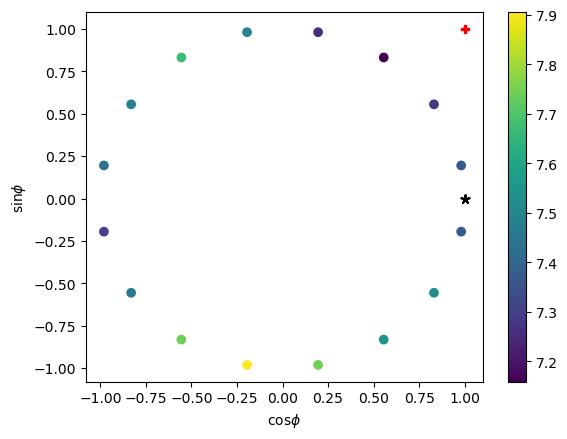

In [93]:
fig, ax = plt.subplots()
Xpolar = np.cos(phis_to_plot)
Ypolar = np.sin(phis_to_plot)
# img = plt.scatter(Xpolar, Ypolar, c = T_new_to_plot)
img = plt.scatter(Xpolar, Ypolar, c = T_near_bh)
plt.scatter(np.cos(phi_peric), np.sin(theta_peric), c = 'r', marker= 'P')
plt.scatter(np.cos(phi_bh), np.sin(theta_bh), c = 'black', marker= (5,2))
plt.xlabel('cos$\phi$')
plt.ylabel('sin$\phi$')
plt.colorbar(img)
#img = ax.pcolormesh(Xpolar, Ypolar, T_new_to_plot, cmap= 'cet_fire', vmin = 0, vmax = 6)


NameError: name 'Xcoord' is not defined

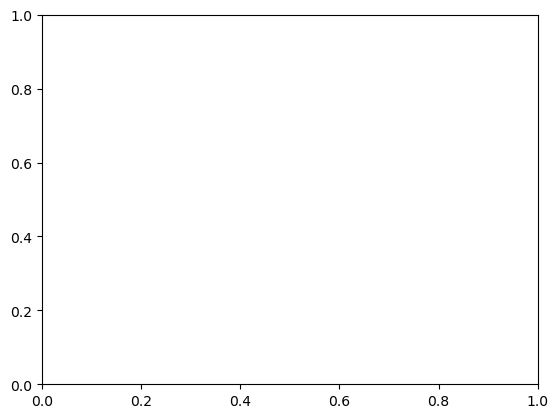

In [94]:
fig, ax = plt.subplots()
img = ax.pcolormesh(Xcoord, Ycoord, plot_density, cmap= 'cet_fire', vmin = 0, vmax = 6)
fig.colorbar(img)
plt.grid(True)
plt.show()

In [ ]:
# fig, ax = plt.subplots(1,1, subplot_kw=dict(projection="mollweide"))
# img = ax.pcolormesh(phis,thetas, plot_density, cmap= 'cet_fire', vmin = 0, vmax = 6)
# plt.scatter(phi_peric, theta_peric, c = 'r')
# fig.colorbar(img)
# plt.grid(True)
# plt.show()
